# Model

Demonstrating a trained model that will be able to classify whether or not I would recommend an anime.

## Setup

In [97]:
import csv
import json
import os
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import DataFrame

# suppress possible unsupported kanji unicode in plots
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,train_test_split

In [98]:
SEED = 1337
data_dir = os.path.abspath('data')

# today = datetime.today().strftime('%Y%m%d')
today = datetime.strptime('2022-09-27', '%Y-%m-%d').strftime('%Y%m%d')

In [99]:
enriched_df = pd.read_csv(os.path.join(data_dir, f'user-{today}-enriched.csv'))

## Encoding / Feature Engineering

In [100]:
# binary encode a column of categorical data
def binary_encode(df: DataFrame, col: str) -> DataFrame:
    try:
        df[col] = df[col].apply(json.loads) # deserialize JSON array
    except ValueError: pass
    except TypeError:  pass

    encoded = df.explode(col) # expand categorical data into rows
    encoded = pd.concat([df, pd.get_dummies(encoded[col], prefix=col, prefix_sep='_')], axis=1) # convert to indicators
    encoded = encoded.groupby('id').max().reset_index() # squash rows
    return encoded.drop([col], axis=1) # drop encoded column

def would_recommend(score: int) -> bool:
    return score >= 7

In [101]:
encode_cols = ['genres', 'studios', 'tags', 'source', 'season_year', 'format']

# drop unused features
enriched_df.drop(['episodes', 'season'], axis=1, inplace=True)

# condense scores to three rating levels
enriched_df['recommend'] = enriched_df['score'].apply(would_recommend)
enriched_df.drop(['score'], axis=1, inplace=True)

In [102]:
# Binary encodes tags,genres,studios. Binary encoding eliminates possible
# data leaks that occur with one-hot encoding since it retains one row per entity.

# binary encode each categorical column
for col in encode_cols:
    enriched_df = binary_encode(enriched_df, col)
enriched_df.drop(['id'], axis=1, inplace=True)

print(enriched_df.shape)

(556, 458)


## Split Data

In [103]:
# split data into train,test,validation sets

X = enriched_df[enriched_df.columns.drop(['recommend'])]
y = enriched_df['recommend']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED, shuffle=True) # stratify=y
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.75, random_state=SEED, shuffle=True)

print('X_train =', X_train.shape, '; y_train =', y_train.shape)
print('X_valid =', X_valid.shape, '; y_valid =', y_valid.shape)
print('X_test =', X_test.shape, '; y_test =', y_test.shape)

# save to CSV for quick glancing data
X_train.to_csv(os.path.join(data_dir, f'user-{today}-cls-train.csv'), index=False)
X_valid.to_csv(os.path.join(data_dir, f'user-{today}-cls-valid.csv'), index=False)
X_test.to_csv(os.path.join(data_dir, f'user-{today}-cls-test.csv'), index=False)

X_train = (333, 457) ; y_train = (333,)
X_valid = (111, 457) ; y_valid = (111,)
X_test = (112, 457) ; y_test = (112,)


## Train

In [104]:
def print_model_results(y_test, y_pred):
    print('Log loss =', metrics.log_loss(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=6))

def display_roc(y_test, y_proba):
    roc = metrics.roc_auc_score(y_test, y_proba) # closer to one, more accurate
    print('ROC AUC Score =', roc)

    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color='g')

Log loss = 6.784516734347483
[[15 16]
 [ 6 75]]
              precision    recall  f1-score   support

       False   0.714286  0.483871  0.576923        31
        True   0.824176  0.925926  0.872093        81

    accuracy                       0.803571       112
   macro avg   0.769231  0.704898  0.724508       112
weighted avg   0.793760  0.803571  0.790394       112

ROC AUC Score = 0.8454798884906413
CPU times: total: 234 ms
Wall time: 248 ms


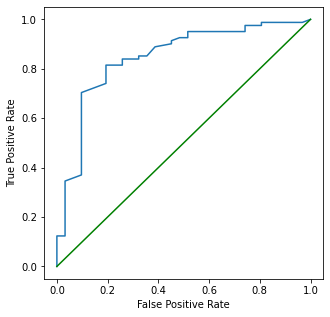

In [105]:
%%time

# Train with base hyperparameters

model = RandomForestClassifier(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

In [106]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = {'max_features': 20, 'n_estimators': 175}

# Other hyperparameter sets:
# hyper_best = {'max_features': 32, 'n_estimators': 100} # 83.04
# hyper_best = {'max_features': 24, 'n_estimators': 150} # 83.93
# hyper_best = {'max_features': 20, 'n_estimators': 150} # 84.82
# hyper_best = {'max_features': 20, 'n_estimators': 175} # 85.71

if not hyper_best:
    param_grid = {
        'n_estimators': [150, 200],
        'max_features': [20, 32, 64, 128],
    }
    hyper_search = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=4).fit(X_valid, y_valid)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Best hyperparameters = {'max_features': 20, 'n_estimators': 175}
CPU times: total: 0 ns
Wall time: 0 ns


## Evaluate

Log loss = 4.934196584711905
[[19 12]
 [ 4 77]]
              precision    recall  f1-score   support

       False   0.826087  0.612903  0.703704        31
        True   0.865169  0.950617  0.905882        81

    accuracy                       0.857143       112
   macro avg   0.845628  0.781760  0.804793       112
weighted avg   0.854351  0.857143  0.849922       112

ROC AUC Score = 0.8524492234169653
CPU times: total: 281 ms
Wall time: 284 ms


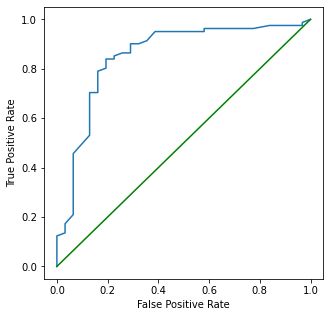

In [107]:
%%time

# Retrain model with new hyperparameters

model = RandomForestClassifier(**hyper_best, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])